## <b>Make Cutout Images of COSMOS-Web Survey</b>

<p style="line-height:1.5">
This is an example Jupyter notebook to make and check JWST cutout images from the COSMOS-Web survey (<a href="https://ui.adsabs.harvard.edu/abs/2023ApJ...954...31C/abstract" target="_blank">Casey et al. 2023</a>).<br>
This notebook <b>assumes that the COSMOS-Web images are stored in your local machine</b>.<br>
If not, <b>download those images first</b> (see <i>"get_cosmosweb_imgs.py"</i>).<br>
</p>




### Import some modules

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

# sys.path.append('/md/imsang/forGit/imsang_cosmosweb')
sys.path.append('../')
import cutout_cosmosweb as ccw

### 1. Make Cutouts of COSMOS-Web

<p style="line-height:1.5">
Let's make some example cutout images of COSMOS-Web images.<br>
Below are the coordinates for this example.<br>

- Object 1: (RA, DEC) = (149.860000, 2.148611)
- Object 2: (RA, DEC) = (149.811667, 2.251389)
- Object 3: (RA, DEC) = (150.240833, 2.064667)
- Object 4: (RA, DEC) = (149.930750, 1.971111)

</p>



In [2]:
## Set the Sky Positions ##
RAs  = [149.860000, 149.811667, 150.240833, 149.930750]
DECs = [2.148611, 2.251389, 2.064667, 1.971111]
objCoords = SkyCoord(ra=RAs*u.deg, dec=DECs*u.deg)


## Make the Cutouts ##
jwst_pwd    = f"../data/"
jwst_filter = "f277w"
dr          = 0.5
pixelScale  = 30
cutoutSize  = 20 * u.arcsec 

sciCutouts, errCutouts, bpmCutouts, objData = ccw.make_COSMOSWeb_cutouts(objCoords, jwst_pwd=jwst_pwd, jwst_filter=jwst_filter, dr=dr, size=cutoutSize, pixelScale=pixelScale)
display(objData)


,RA (deg),DEC (deg),inJWST,mosaic,warnNaN
0,149.860000,2.148611,True,A1,False
1,149.811667,2.251389,True,A1,False
2,150.240833,2.064667,True,A4,False
3,149.930750,1.971111,True,A7,False


<p style="line-height:1.5">
"make_COSMOSWeb_cutouts" function will return three cutout images (science, error, bad-pixel mask) and a pd.DataFrame object which contains some information on the cutouts.<br>
</p>



### 2. Check the Cutout Images

<p style="line-height:1.5">
We can check the resulting cutout images as follows.<br>

</p>



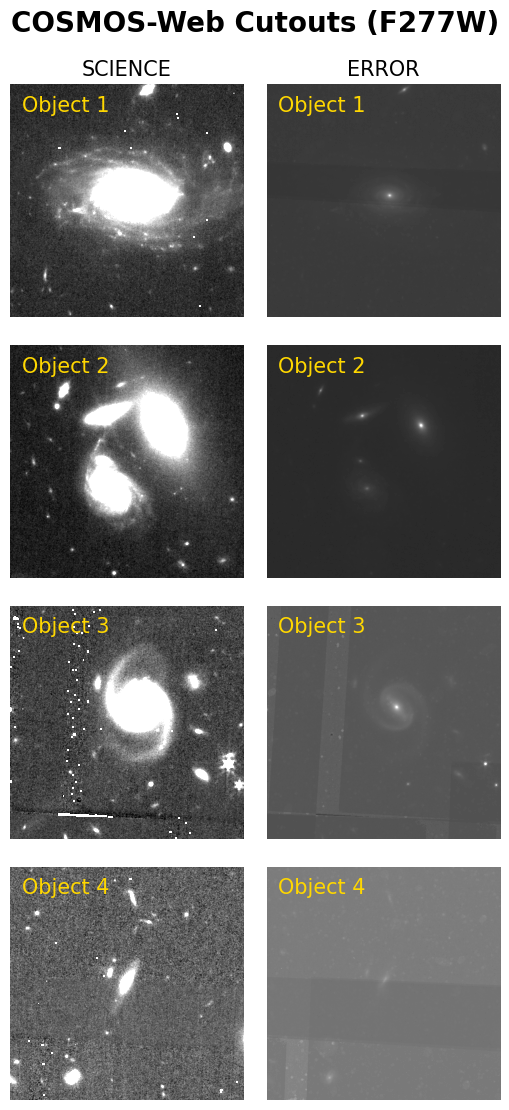

In [3]:
nObjs = len(objData)
fig, axs = plt.subplots(nObjs, 2, figsize = (7,3*nObjs))

for i in range(len(axs)):
    sciImg = sciCutouts[i].data
    errImg = errCutouts[i].data
    
    for j in range(len(axs[i])):
        ax   = axs[i][j]
        data = [sciImg, errImg][j]
        vmin, vmax = interval.get_limits(sciImg)
        
        ax.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

        if (i==0):
            ax.set_title(['SCIENCE', 'ERROR'][j], fontsize=15)
        ax.text(x=0.05, y=0.95, s=f"Object {i+1}", fontsize=15, color='gold', transform=ax.transAxes, ha='left', va='top')
        ax.axis('off')

fig.text(0.5, 0.96, f"COSMOS-Web Cutouts ({jwst_filter.upper()})", ha='center', va='top', fontsize=20, fontweight='bold')

fig.subplots_adjust(left=0.15, bottom=0.05, top=0.9, right=0.85, hspace=0.1, wspace=0.1)

### 3. Save the Cutout Images

<p style="line-height:1.5">
Save the cutout images as FITS files.<br>
</p>


In [4]:
sav_pwd    = f"../cutouts/"

nSci, nErr, nbpm = 0, 0, 0
for i in range(len(objData)):
    ID  = i+1
    RA  = objData['RA (deg)'][i]
    DEC = objData['DEC (deg)'][i]
    haveCutout = objData['inJWST'][i] & np.invert(objData['warnNaN'][i])

    if (haveCutout):
        sciData = sciCutouts[i].data
        errData = errCutouts[i].data
        bpmMask = bpmCutouts[i]
        wcs     = sciCutouts[i].wcs

        sciCutoutHDU = fits.PrimaryHDU(data=sciData, header=wcs.to_header())
        errCutoutHDU = fits.PrimaryHDU(data=errData, header=wcs.to_header())
        bpmCutoutHDU = fits.PrimaryHDU(data=bpmMask, header=wcs.to_header())
        
        sciCutoutHDU.writeto(sav_pwd + f"object_{ID}_COSMOS-Web_JWST_{jwst_filter.upper()}_sci_cutout.fits", overwrite=True)
        errCutoutHDU.writeto(sav_pwd + f"object_{ID}_COSMOS-Web_JWST_{jwst_filter.upper()}_err_cutout.fits", overwrite=True)
        bpmCutoutHDU.writeto(sav_pwd + f"object_{ID}_COSMOS-Web_JWST_{jwst_filter.upper()}_bpm_cutout.fits", overwrite=True)

        nSci += 1
        nErr += 1
        nbpm += 1

print(f" => TOTAL : {nSci} Science Cutouts Saved !")
print(f" => TOTAL : {nErr} Error Cutouts Saved !")
print(f" => TOTAL : {nbpm} BPM Cutouts Saved !")

 => TOTAL : 4 Science Cutouts Saved !
 => TOTAL : 4 Error Cutouts Saved !
 => TOTAL : 4 BPM Cutouts Saved !
